In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm


warnings.filterwarnings('ignore')

project_dir = Path("/media/eden/sandisk/projects/icecube/")
data_dir = project_dir / "input" / "icecube-neutrinos-in-deep-ice"
train_meta = data_dir / "train_meta.parquet"
batch_one = data_dir / "train" / "batch_1.parquet"
geometry_table = data_dir / "sensor_geometry.csv"
submission = data_dir / "sample_submission.parquet"

In [2]:
df_batch = pl.read_parquet(batch_one)


In [35]:
df_batch["time"].max()

77785

In [36]:
events = df_batch["event_id"].unique()[:5000]
df_samples = df_batch.filter(pl.col("event_id").is_in(events))

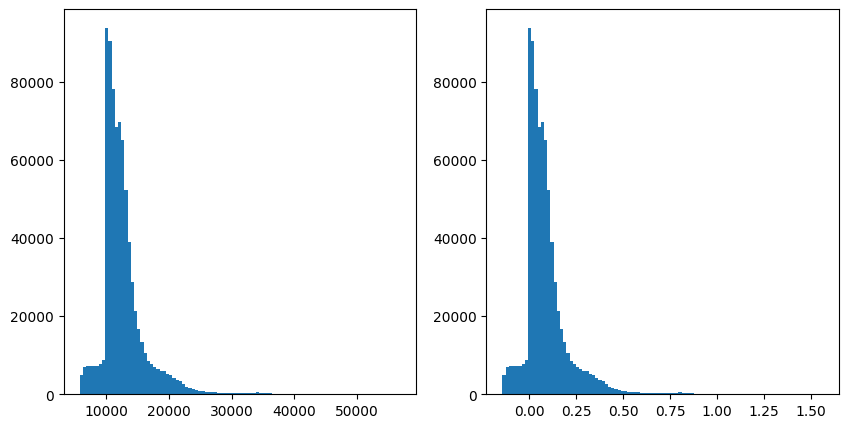

In [43]:
bins = 100

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.hist(df_samples["time"], bins=bins)

fig.add_subplot(1, 2, 2)
plt.hist((df_samples["time"] - 1e4)/ 3e4, bins=bins);

In [44]:
import torch
import torch.nn as nn

class AddPositionalEncoding(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        max_time: int,
    ) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.max_time = max_time
        positional_encoding_weight: torch.Tensor = self._initialize_weight()

        print(positional_encoding_weight.shape)
        self.register_buffer(
            "positional_encoding_weight", positional_encoding_weight
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        return x + self.positional_encoding_weight[:seq_len, :].unsqueeze(0)

    def _get_positional_encoding(self, pos: int, i: int) -> float:
        w = pos / (10000 ** (((2 * i) // 2) / self.embed_dim))
        if i % 2 == 0:
            return np.sin(w)
        else:
            return np.cos(w)

    def _initialize_weight(self) -> torch.Tensor:
        positional_encoding_weight = [
            [
                self._get_positional_encoding(pos, i)
                for i in range(1, self.embed_dim + 1)
            ]
            for pos in range(1, self.max_time + 1)
        ]
        return torch.tensor(positional_encoding_weight).float()

In [45]:
one_event = df_batch.filter(pl.col("event_id") == 24)

In [57]:
df_sensor = pl.read_csv(geometry_table, dtypes={"sensor_id": pl.datatypes.Int16})

In [61]:
one_event = one_event.join(df_sensor, on="sensor_id").drop(columns=["sensor_id", "event_id"])

In [67]:
one_event = one_event.sort(by="time")

In [73]:
one_event = one_event.with_columns(
    (pl.col("time") - pl.col("time").min())
)

In [ ]:
pe = AddPositionalEncoding(128, 256)